In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
x_data = np.array([1, 2, 3, 4, 5])
y_data = x_data * 2

## PyTorch Implementation

In [3]:
x = np.random.rand(50)
x = x * 10

y = x * 3 - 4
y += np.random.randn(50)

x_torch = torch.FloatTensor(x).reshape(-1, 1)
y_torch = torch.FloatTensor(y).reshape(-1, 1)

In [4]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

In [5]:
model = LinearModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Train the model for 1000 epochs.\
1) Do the forward propagation.\
2) Calculate loss\
3) Backpropagation\
4) Update the parameters by using `optimizer.step()`\
5) Zero the gradients

In [6]:
all_loss = []

for epoch in range(1000):
    y_hat = model(x_torch)

    loss = criterion(y_hat, y_torch)
    loss.backward()
    all_loss.append(loss.item())

    optimizer.step()
    optimizer.zero_grad()

In [7]:
y_pred = model.forward(x_torch)

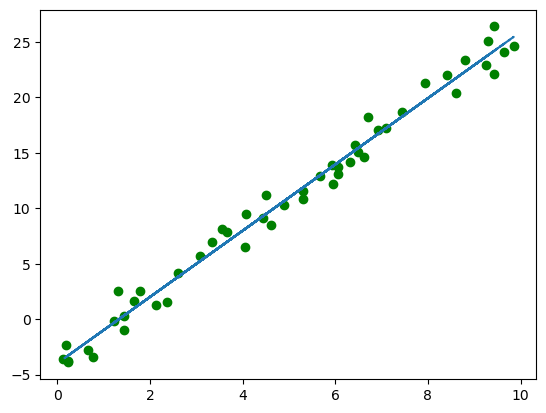

In [8]:
plt.plot(x_torch, y_torch, 'go')
plt.plot(x_torch, y_pred.detach().numpy(), '--')

In [9]:
for name, param in model.named_parameters():
    print(name, param)

linear.weight Parameter containing:
tensor([[2.9874]], requires_grad=True)
linear.bias Parameter containing:
tensor([-3.9658], requires_grad=True)


# Integrating CPHS Data and Code

## Load Data

In [10]:
import pickle

with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block1.pickle", 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, _, _, _, _, _, _ = pickle.load(handle)

#with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block2.pickle", 'rb') as handle:
#    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
#    refs_block2, _, _, _, emgs_block2, _, _, _, _, _, _ = pickle.load(handle)

In [11]:
keys = ['METACPHS_S106', 'METACPHS_S107', 'METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112', 'METACPHS_S113', 'METACPHS_S114', 'METACPHS_S115', 'METACPHS_S116', 'METACPHS_S117', 'METACPHS_S118', 'METACPHS_S119']
key_to_num = dict()
num_to_key = dict()
for idx, key in enumerate(keys):
    key_to_num[key] = idx
    num_to_key[idx] = key

num_conds = 8
num_channels = 64
num_updates = 19
cphs_starting_update = 10
update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]

In [12]:
print(f"EMG Input shape: {emgs_block1[keys[0]].shape}")
print(f"2D Velocity Label shape: {refs_block1[keys[0]].shape}")

EMG Input shape: (8, 20770, 64)
2D Velocity Label shape: (8, 20770, 2)


In [13]:
print("Condition 1")
F1tens_full = torch.from_numpy(emgs_block1[keys[0]][0, :, :])
VREF1tens_full = torch.from_numpy(refs_block1[keys[0]][0, :, :])

Condition 1


In [14]:
torch.cuda.is_available()

False

In [15]:
# 2-norm
#x.norm(dim=1, p=2)
#torch.linalg.norm(x, dim=1, ord=2)
#x.pow(2).sum(dim=1).sqrt()

# https://pytorch.org/docs/stable/generated/torch.norm.html

In [16]:
# TENSOR-IFY THIS FUNCTION!!!
def cost_l2_torch(F, D, V, learning_batch, lambdaF=1e-7, lambdaD=1e-3, lambdaE=1e-6, Nd=2, Ne=64):
    # c_L2 = (lambdaE||DF + V+||_2)^2 + lambdaD*(||D||_2)^2 + lambdaF*(||F||_2)^2
    
    '''
    F: 64 channels x time EMG signals
    V: 2 x time target velocity
    D: 2 (x y vel) x 64 channels decoder
    H: 2 x 2 state transition matrix
    alphaE is 1e-6 for all conditions
    ''' 

    Nt = learning_batch
    D = np.reshape(D,(Nd,Ne))
    Vplus = V[:,1:]
    # Performance
    term1 = lambdaE*(np.linalg.norm((D@F - Vplus))**2)
    # D Norm
    term2 = lambdaD*(np.linalg.norm(D)**2)
    # F Norm
    term3 = lambdaF*(np.linalg.norm(F)**2)
    return (term1 + term2 + term3)

In [17]:
num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
# ^ IRL I'm not sure we are guaranteed to get equalength trials
#  Thus may be better to do every time point individually? Not sure
output_size = 2  # 2D Velocity

learning_rate = 0.01

In [18]:
model = LinearModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [19]:
x = np.random.rand(50)
x = x * 10

y = x * 3 - 4
y += np.random.randn(50)

x_torch = torch.FloatTensor(x).reshape(-1, 1)
y_torch = torch.FloatTensor(y).reshape(-1, 1)

In [20]:
y_torch.shape

torch.Size([50, 1])

In [21]:
all_loss = []

for epoch in range(1000):
    y_hat = model(x_torch)

    loss = criterion(y_hat, y_torch)
    loss.backward()
    all_loss.append(loss.item())

    optimizer.step()
    optimizer.zero_grad()

In [ ]:
y_pred = model.forward(x_torch)

In [ ]:
plt.plot(x_torch, y_torch, 'go')
plt.plot(x_torch, y_pred.detach().numpy(), '--')

In [ ]:
for name, param in model.named_parameters():
    print(name, param)

In [23]:
# Other option which should give same result:
model = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr

In [25]:
model.weight.shape

torch.Size([2, 64])

In [ ]:
assert(1==0)

In [ ]:
num_epochs = 100
loss_log = []
criterion = cost_l2_torch
for my_epoch in range(num_epochs):
    # forward pass and loss
    y_pred = model(X)
    #loss = criterion(emg_streamed_batch, model.weight, IDK, emg_streamed_batch.shape[0])
    #F, D, V, learning_batch

    
    # backward pass
    loss.backward()
    loss_log.append(loss.item())
    
    # update
    optimizer.step()
    
    optimizer.zero_grad()
    
    if (my_epoch+1)%10==0:
        print(f"Epoch: {my_epoch+1}, loss: {loss.item():.4f}")

In [ ]:
# I can't run this code since my data isn't 1D...
#predicted = model(X).detach().numpy()
#plt.plot(X_numpy, y_numpy, 'ro')
#plt.plot(X_numpy, predicted, 'b')
#plt.show()

# Plot loss per epoch instead
plot.plot(range(num_epochs), loss_log)
plt.title("Training Loss Per Epoch")
plt.show()